# Système multi-agents pour reprise d'installations électiques

L'objectif final est de concevoir une méthodologie pour former une stratégie de réparation du système de distribution HTA en situation de crise.

Techniquement, la conception est divisée en trois parties complémentaires :

    1 - Simuler l'environnement du système de distribution HTA -Anylogic- 
    2 - Sélectionner l'algorithme d'apprentissage par renforcement le plus pertinent pour ce type de problème -PPO- 
    3 - Construire un lien entre le simulateur et l'algorithme d'entraînement RL.

Ensuite, nous lançons l'entraînement du modèle RL sur le simulateur d'environnement et enfin, nous testons notre simulation avec le modèle entraîné.


Remarque :
    
    - Créez un nouveau environnement et installer tous les packages nécessaires
    - N'oubliez pas de changer les chemin d'accès dans le code.

## Implémentation de PPO :

Proximal Policy Optimization (PPO) est utilisée dans plusieurs solutions pour entraîner un modèle de décision sur un environnement industriel. PPO permet d'entraîner un modèle sur un espace d'actions discrètes ou continues. Il est plus rapide à converger et surpasse A2C et DDPG avec de bonnes performances.



Article de "Towards Data Science":
The idea is that PPO improves the stability of the Actor training by limiting the policy update at each training step.


In [8]:
import argparse
import os
import random
import time
from distutils.util import strtobool
import numpy as np
# on utilise Pytorch pour construire et entrainer notre modele PPO
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical
from torch.utils.tensorboard import SummaryWriter
import time
import matplotlib.pyplot as plt


# Les observations sur lesquelles on travaille 

[etatequipement=[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], disponibleequipe=[1, 1, 1], emplequipe=[50, 50, 50], recompns=15500.0]

# Les actions à prendre doivent être sous la forme 

a.req1 = 2  # l'equipe 1 vers l'équipement 1

a.req2 = 6 # l'equipe 2 vers l'équipement 2

a.req3 = 48 # l"equipe 3 vers l'equipement 3

In [9]:
import alpyne
from alpyne.client import alpyne_client
from alpyne.client.alpyne_client import AlpyneClient
from alpyne.data.spaces import Action

In [10]:
# initialisation d'une couche de Réseau de Neurones - Neural Network 'NN'
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    #Transforme en matrice orthogonale
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

In [11]:
class agent_PPO(nn.Module):
    '''
    Attention ! Il reste des 'len' à modifier par des .size si jamais on les met sous forme de tenseur pytorch
    '''

    def __init__(self,obs0):
       #on considère que obs0 est l'objet alpyne des observations initiales
       #super().__init__ permet d'indiquer que agent_PPO est une sous-classe de nn.Module 
        super(agent_PPO,self).__init__()

        self.obs0=obs0
        self.n_equipe=len(obs0.disponibleequipe)
        self.n_equipement=len(obs0.etatequipement)

        #std = variance
        self.critic = nn.Sequential(
            layer_init(nn.Linear(self.n_equipement, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 1), std=1.0),
            
        )
        # NN de actor (pour la politique)
        self.actor = nn.Sequential(
            layer_init(nn.Linear(self.n_equipement, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, self.n_equipement*self.n_equipe), std=0.01))
    

    def get_value(self, x):
        return self.critic(x)

    def get_action_and_value(self, x, action=None):
        #Les logits sont les probabilités de chaque action 
        logits = self.actor(x)
        if logits.nelement()>self.n_equipe*self.n_equipement:
            logits=logits.reshape([x.size(0),self.n_equipe,self.n_equipement])
        else:
            logits=logits.reshape([self.n_equipe,self.n_equipement])
        probs = Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy(), self.critic(x)



# Les paramètres 

Set de paramètres 1

In [12]:
# seed des expériences
seed =1

# Le nombre des environnements parallèles
num_envs = 1
# Le nombre de pas à exécuter dans un seul environnement pendant la phase policy rollout (128)
num_steps =128

# Le nombre total des pas-de-temps des expériences
total_timesteps = 128 #500 de base

gamma=0.95 #Discount qui prend en compte jusqu'à 100 étapes dans le calcul de la reward 


# Pour réduire le pas d'apprentissage(learning_rate) des NN, politique(Pi) et valeur (VF) "
anneal_lr = True

learning_rate = 2.5e-4 #Pas d'apprentissage de l'optimizer, on pourra essayer quelque chose de l'ordre de 10^-3 par la suite 

batch_size = int(num_envs * num_steps)
num_minibatches = 4

minibatch_size = int(batch_size // num_minibatches)

epochs=10

epsilon_greedy=0.1 #Probabilité d'explorer initiale 

# Lambda pour GAE
gae_lambda = 0.95

# Utilisation de GAE : General Advantage Estimation 
gae = True

# le seuil de KL divergence
target_kl = None

# permmettre la normalisation de l'advantages (soustraire la moyenne / diviser par l'écart type)
norm_adv = True

# le coefficient de clipping PPO (epsilon)
clip_coef = 0.2
# Permettre l'utilisation de clipped loss dans la fonction valeur
clip_vloss = True

#Coefficient d'entropie. Dans le PPO un coefficient d’entropie est multiplié à l’entropie maximale possible 
# et ajouté à la fonction objectif. Ceci contribue à la régularisation en prévenant une convergence prématurée 
# vers une action de probabilité élevée. Entropie élevée : actions équiprobables

ent_coef = 0.01
# coefficient de la fonction valeur dans la fonction obj
vf_coef = 0.5
# la norme maximale pour le gradient clipping
max_grad_norm = 0.5

# les K epochs pour mise à jour la politique
update_epochs = 4

Set de paramètres 2

In [109]:
# seed des expériences
seed =1

# Le nombre des environnements parallèles
num_envs = 1
# Le nombre de pas à exécuter dans un seul environnement pendant la phase policy rollout (128)
num_steps =128

# Le nombre total des pas-de-temps des expériences
total_timesteps = 128 #500 de base

gamma=0.95 #Discount qui prend en compte jusqu'à 100 étapes dans le calcul de la reward 


# Pour réduire le pas d'apprentissage(learning_rate) des NN, politique(Pi) et valeur (VF) "
anneal_lr = True

learning_rate = 2.5e-3 

batch_size = int(num_envs * num_steps)
num_minibatches = 4

minibatch_size = int(batch_size // num_minibatches)

epochs=10

epsilon_greedy=0.1 #Probabilité d'explorer initiale 

# Lambda pour GAE
gae_lambda = 0.95

# Utilisation de GAE : General Advantage Estimation 
gae = True

# le seuil de KL divergence
target_kl = None

# permmettre la normalisation de l'advantages (soustraire la moyenne / diviser par l'écart type)
norm_adv = True

# le coefficient de clipping PPO (epsilon)
clip_coef = 0.2
# Permettre l'utilisation de clipped loss dans la fonction valeur
clip_vloss = True

#Coefficient d'entropie. Dans le PPO un coefficient d’entropie est multiplié à l’entropie maximale possible 
# et ajouté à la fonction objectif. Ceci contribue à la régularisation en prévenant une convergence prématurée 
# vers une action de probabilité élevée. Entropie élevée : actions équiprobables

ent_coef = 0.01
# coefficient de la fonction valeur dans la fonction obj
vf_coef = 0.5
# la norme maximale pour le gradient clipping
max_grad_norm = 0.3

# les K epochs pour mise à jour la politique
update_epochs = 3

# Initialisation d'alpyne

In [ ]:
# Cette instance est créée pour lancer l'environnement de simulation.
# Pour lancer la simulation le modèle de simulation anylogic doit etre fini avec la classe RLExperiment et exporté.
# Il faut mettre l'emplacement du modèle exporté de Anylogic.
client = AlpyneClient(r"/Volumes/Stock/IA/Code/Anylogic/RL_Anylogic/Exported/model.jar", verbose = True, port = 51150)

In [111]:
# initialisation de la configuration du simulateur 
cfg = client.configuration_template
cfg.nbequipe = 3
cfg.engine_seed = 1  

In [112]:
# lancement d'une simulation avec la configuration initiale
sim = client.create_reinforcement_learning(cfg)
sim=sim.run()

2023-01-05 11:00:42,017 [alpyne.client.http_client @ 31][   DEBUG] POST /runs: {'experimentType': <ExperimentType.REINFORCEMENT_LEARNING: 'REINFORCEMENT_LEARNING'>, 'inputs': [nbequipe:INTEGER=3, {START_TIME}:DOUBLE=0 HOUR, {START_DATE}:DATE_TIME=2019-12-31T23:00:00Z, {STOP_TIME}:DOUBLE=inf HOUR, {STOP_DATE}:DATE_TIME=None, {RANDOM_SEED}:LONG=1]}
2023-01-05 11:00:42,625 [alpyne.client.http_client @ 64][   DEBUG] => 201 (Created) [('Location', 'http://127.0.0.1:51150/runs/1'), ('Content-Type', 'application/json'), ('Connection', 'close'), ('Content-Length', '147')] {'message': '{"reason":null,"next_event_time":"-Infinity","episode_count":1,"step_count":0,"model_time":0.0}', 'id': 1, 'status': 'RUNNING'}


In [113]:
obs=sim.get_observation()
agent=agent_PPO(obs)
print(obs)

2023-01-05 11:00:45,500 [alpyne.client.http_client @ 31][   DEBUG] POST /runs/1/rl: {'command': 'OBSERVATION'}
2023-01-05 11:00:45,616 [alpyne.client.http_client @ 64][   DEBUG] => 200 (OK) [('Content-Type', 'application/json'), ('Connection', 'close'), ('Content-Length', '339')] [{'name': 'etatequipement', 'type': 'INTEGER_ARRAY', 'value': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]}, {'name': 'disponibleequipe', 'type': 'INTEGER_ARRAY', 'value': [1, 1, 1]}, {'name': 'emplequipe', 'type': 'INTEGER_ARRAY', 'value': [50, 50, 50]}, {'name': 'recompns', 'type': 'DOUBLE', 'value': 0.0}]


[etatequipement=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0], disponibleequipe=[1, 1, 1], emplequipe=[50, 50, 50], recompns=0]


# Entrainement

Intialisation de la liste des rewards moyennes (pour observer les performances)

In [114]:
listRewardAvg=[]
listLossAvg=[]

In [115]:
def train():

    # Initialiser l'environnement
    # client = AlpyneClient(r"/Volumes/Stock/IA/Code/Anylogic/RL_Anylogic/Exported/model.jar", verbose = True, port = 51150)

    # cfg = client.configuration_template
    # cfg.nbequipe = 3
    # cfg.engine_seed = 1  
    # sim = client.create_reinforcement_learning(cfg)
    # sim=sim.run()
    # obs=sim.get_observation()
    # print("new sim :",obs.etatequipement)
    # agent=agent_PPO(obs)

    global agent
    global sim

    listReward=torch.Tensor([])
    listLoss=torch.Tensor([])

    # Initialiser l'agent    
    optimizer = torch.optim.Adam(agent.parameters(), lr=learning_rate, eps=1e-5)

    # Initialisation de l'espace de stockage (buffer) 
    obs = torch.zeros((num_steps, agent.n_equipement,num_envs)) # Une colonne = 1 environnement différent si on veut upgrade 
    actions = torch.zeros((num_steps, agent.n_equipe,num_envs))
    logprobs = torch.zeros((num_steps,agent.n_equipe, num_envs))
    rewards = torch.zeros((num_steps, num_envs))
    dones = torch.zeros((num_steps, num_envs))
    values = torch.zeros((num_steps, num_envs))

    # Commencer l'entrainement
    global_step = 0
    start_time = time.time()
    next_obs = torch.Tensor(sim.get_observation().etatequipement) # APLYNE, attention : fonctionnel pour un seul environnement
    next_obs=next_obs[:,None ] #À modifier si jamais il y a plus d'un env 
    next_done = torch.zeros(num_envs)
    num_updates = total_timesteps // batch_size
    for update in range(1, num_updates + 1):
        # Déminuer le taux d'apprentissage si aneal_lr : vrai
        '''
        print("new sim :",sim.get_observation().etatequipement)
        next_obs= torch.Tensor(sim.get_observation().etatequipement)
        next_obs=next_obs[:,None ]
        '''
        
        if anneal_lr:
            frac = 1.0 - (update - 1.0) / num_updates
            lrnow = frac * learning_rate
            optimizer.param_groups[0]["lr"] = lrnow #Pour changer le learning rate de l'optimizer
        #Phase rollout
        for step in range(num_steps):
            global_step+=1*num_envs
            obs[step]=next_obs #Observations sur le nombre total d'étapes (steps) pour chaque environnement, pour l'instant un seul
            dones[step]=next_done
            with torch.no_grad():
                action,log_prob,_,value=agent.get_action_and_value(next_obs.flatten()) #Changer le flatten en reshape pour plusieurs env
                values[step]=value.flatten()
            
            action=action[:,None ] #À modifier si jamais il y a plus d'un env 
            actions[step]=action

            log_prob=log_prob[:,None]
            logprobs[step]=log_prob

            #Execution des actions
            a=client.action_template

            # A CHANGER
            a.req1=action[0].item()
            a.req2=action[1].item()
            a.req3=action[2].item()

            #
            sim.take_action(a)
            observ=sim.get_observation()
            next_obs,reward,done=observ.etatequipement,observ.recompns,sim.is_terminal()

            reward=torch.Tensor([reward]).view(-1)
            reward=reward[:,None]

            rewards[step]=reward

            listReward=torch.cat((listReward,reward))

            next_obs,next_done=torch.Tensor(next_obs),torch.Tensor([done])
            next_obs=next_obs[:,None ] #À modifier si jamais il y a plus d'un env


            print(f'\r global_step={global_step}, step={step}, reward={reward}')
        # Calcul de la fonction Advantage
        with torch.no_grad():
            next_value = agent.get_value(next_obs.flatten()).reshape(1, -1)
            if gae:
                advantages = torch.zeros_like(rewards)
                lastgaelam = 0
                for t in reversed(range(num_steps)):
                    if t == num_steps - 1:
                        nextnonterminal = 1.0 - next_done
                        nextvalues = next_value
                    else:
                        nextnonterminal = 1.0 - dones[t + 1]
                        nextvalues = values[t + 1]
                    delta = rewards[t] + gamma * nextvalues * nextnonterminal - values[t]
                    advantages[t] = lastgaelam = delta + gamma * gae_lambda * nextnonterminal * lastgaelam
                returns = advantages + values
            else:
                returns = torch.zeros_like(rewards)
                for t in reversed(range(num_steps)):
                    if t == num_steps - 1:
                        nextnonterminal = 1.0 - next_done
                        next_return = next_value
                    else:
                        nextnonterminal = 1.0 - dones[t + 1]
                        next_return = returns[t + 1]
                    returns[t] = rewards[t] + gamma * nextnonterminal * next_return
                advantages = returns - values

        # le batch : avoir un vecteur de tous les éléments utilisés
        b_obs = obs.reshape((-1,) + (len(observ.etatequipement),))
        b_logprobs = logprobs.reshape((-1,) + (agent.n_equipe,))
        b_actions = actions.reshape((-1,) + (len(observ.disponibleequipe),))
        b_advantages = advantages.reshape(-1)
        b_returns = returns.reshape(-1)
        b_values = values.reshape(-1)

        # Optimisation de la fonction valeur et la politique
        b_inds = np.arange(batch_size)
        clipfracs = []
        for epoch in range(update_epochs):
            np.random.shuffle(b_inds)
            # mini-batching
            for start in range(0, batch_size, minibatch_size):
                end = start + minibatch_size
                mb_inds = b_inds[start:end]
                #print("mb_inds size is:",mb_inds.shape)
                #print("L'élément perturbateur size :",b_obs[mb_inds].size())

                _, newlogprob, entropy, newvalue = agent.get_action_and_value(b_obs[mb_inds], b_actions.long()[mb_inds])

                #print("new log prob size :",newlogprob.size())
                #print('b_logprobs size :',b_logprobs[mb_inds].size())
                logratio = newlogprob - b_logprobs[mb_inds]
                ratio = logratio.exp()

                with torch.no_grad():
                    # calcul de approx_kl http://joschu.net/blog/kl-approx.html
                    old_approx_kl = (-logratio).mean()
                    approx_kl = ((ratio - 1) - logratio).mean()
                    clipfracs += [((ratio - 1.0).abs() > clip_coef).float().mean().item()]
                    ratio=ratio.sum(dim=-1) # À MODIFIER PLUS TARD

                mb_advantages = b_advantages[mb_inds]
                # normalisation de l'avantage 
                if norm_adv:
                    mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)
                # Coût associé à la politique
                pg_loss1 = -mb_advantages * ratio
                pg_loss2 = -mb_advantages * torch.clamp(ratio, 1 - clip_coef, 1 + clip_coef)
                pg_loss = torch.max(pg_loss1, pg_loss2).mean()

                # Coût associé à la fonction valeur
                newvalue = newvalue.view(-1)
                if clip_vloss:
                    v_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
                    v_clipped = b_values[mb_inds] + torch.clamp(
                        newvalue - b_values[mb_inds],
                        -clip_coef,
                        clip_coef,
                    )
                    v_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
                    v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                    v_loss = 0.5 * v_loss_max.mean()
                else:
                    v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()

                entropy_loss = entropy.mean()
                loss = pg_loss - ent_coef * entropy_loss + v_loss * vf_coef

                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
                optimizer.step()
                with torch.no_grad():
                    loss=torch.tensor([loss.item()])
                    listLoss=torch.cat((listLoss,loss))

            # early stopping
            if target_kl is not None:
                if approx_kl > target_kl:
                    break
        
            #print("epoch loss is :",loss)
    y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
    var_y = np.var(y_true)
    end_time=time.time()
    print("computation time :",end_time-start_time)
    return listReward,listLoss
        
    explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y



# Cellules à exécuter pour provoquer un reset 

In [ ]:
listReward,listLoss=train()

In [165]:
sim = client.create_reinforcement_learning(cfg)
sim=sim.run()

rewardAvg=(sum(listReward).item())/listReward.size(0)
lossAvg=(sum(listLoss).item())/listLoss.size(0)

listRewardAvg.append(rewardAvg)
listLossAvg.append(lossAvg)

print("rewardAvg:",rewardAvg)
print("lossAvg:",lossAvg)

2023-01-05 11:21:13,990 [alpyne.client.http_client @ 31][   DEBUG] POST /runs: {'experimentType': <ExperimentType.REINFORCEMENT_LEARNING: 'REINFORCEMENT_LEARNING'>, 'inputs': [nbequipe:INTEGER=3, {START_TIME}:DOUBLE=0 HOUR, {START_DATE}:DATE_TIME=2019-12-31T23:00:00Z, {STOP_TIME}:DOUBLE=inf HOUR, {STOP_DATE}:DATE_TIME=None, {RANDOM_SEED}:LONG=1]}
2023-01-05 11:21:14,046 [alpyne.client.http_client @ 64][   DEBUG] => 201 (Created) [('Location', 'http://127.0.0.1:51150/runs/21'), ('Content-Type', 'application/json'), ('Connection', 'close'), ('Content-Length', '148')] {'message': '{"reason":null,"next_event_time":"-Infinity","episode_count":1,"step_count":0,"model_time":0.0}', 'id': 21, 'status': 'RUNNING'}


rewardAvg: 304.6875
lossAvg: 21663749.333333332


In [166]:
print(listRewardAvg)
print(listLossAvg)
print(len(listRewardAvg))

[-7.8125, 156.25, -203.125, 406.25, 324.21875, 371.09375, 132.8125, 378.90625, 152.34375, 437.5, 269.53125, 324.21875, 31.25, -39.0625, 183.59375, 277.34375, 148.4375, 203.125, 78.125, 304.6875]
[19199197.333333332, 19784117.333333332, 10721678.666666666, 32112362.666666668, 18233776.0, 30125349.333333332, 25111650.666666668, 23260010.666666668, 21160240.0, 29243514.666666668, 17934406.666666668, 27644464.0, 21946213.333333332, 15269498.666666666, 25026642.666666668, 22540000.0, 22008416.0, 24031144.0, 27868322.666666668, 21663749.333333332]
20


# Tracés de graphes

In [167]:
maxReward=max(listRewardAvg)
maxLoss=max(listLossAvg)

normListRewardAvg=[i/maxReward for i in listRewardAvg]
normListLossAvg=[i/maxLoss for i in listLossAvg]

listIndex=np.arange(1,len(listRewardAvg)+1)

Graphe de la reward moyenne par epoch

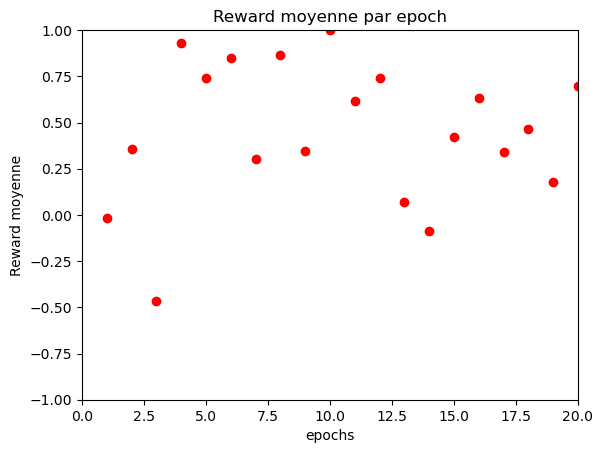

In [168]:
plt.plot(listIndex,normListRewardAvg,'ro')
plt.axis([0,len(listIndex),-1,1])
plt.title("Reward moyenne par epoch")
plt.xlabel("epochs")
plt.ylabel("Reward moyenne")

plt.show()

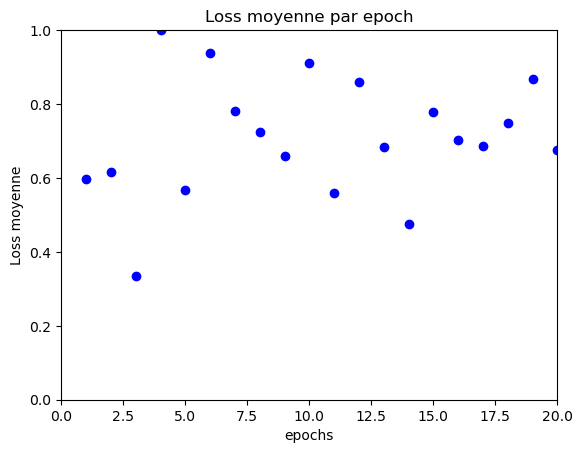

In [169]:
plt.plot(listIndex,normListLossAvg,'bo')
plt.axis([0,len(listIndex),0,1])
plt.title("Loss moyenne par epoch")
plt.xlabel("epochs")
plt.ylabel("Loss moyenne")

plt.show()

In [104]:
print(normListRewardAvg[-1])

-0.5877862595419847


In [148]:
PATH="/Volumes/Stock/IA/Code/Anylogic/RL_Anylogic/model_saved.txt"
torch.save(agent.state_dict(), PATH)